In [1]:
import sys
sys.path.insert(0, '../../../')

%load_ext autoreload
%autoreload 2

import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
from catalyst.dl.callbacks import InferCallback, CheckpointCallback
from model import FinalSegment
from torch.utils.data import DataLoader
from mlcomp.contrib.dataset.segment import ImageWithMaskDataset
from experiment import Experiment
from catalyst.dl.experiments import SupervisedRunner
import collections
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from processor import ImgProcessor
import shutil
import pretrainedmodels
from scipy.special import softmax
from os.path import join

In [2]:
filtered_images = set([os.path.basename(f) for f in glob('data/filter/images/**/*.*', recursive=True)])

### Top predictions

In [3]:
dataset = ImageWithMaskDataset(img_folder='data/img', 
                                 fold_csv='data/fold.csv', 
                                 fold_number=0,
                                 is_test=True,
                                 gray_scale=True,
                                 transforms= Experiment.transforms_valid()
                                )

In [4]:
model = FinalSegment(num_classes=3, in_channels=1)
runner = SupervisedRunner()
loader = DataLoader(dataset, batch_size=8, shuffle=False)
loaders = collections.OrderedDict([("infer", loader)])
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(resume='log/checkpoints/best.pth'),
        InferCallback()
    ],
    verbose=True
)

=> loading checkpoint "log/checkpoints/best.pth"
loaded checkpoint "log/checkpoints/best.pth" (epoch 53)
0/1 * Epoch (infer): 100% 151/151 [00:36<00:00,  1.39it/s, _timers/_fps=4.227]  
Top best models:



In [10]:
img_folder = 'data/filter/images/004'
lbl_folder = 'data/filter/labels/004'

shutil.rmtree(img_folder, ignore_errors=True)
shutil.rmtree(lbl_folder, ignore_errors=True)
os.makedirs(img_folder, exist_ok=True)
os.makedirs(lbl_folder, exist_ok=True)

# prob = softmax(runner.callbacks[1].predictions['logits'], axis=1)
# prob

sigmoid = lambda x: 1/(1 + np.exp(-x))
cathode_threshold = 0.3
anode_threshold = 0.1
to_draw = False

for i, (item, output) in enumerate(zip(dataset.data, runner.callbacks[1].predictions["logits"])):
    image = cv2.imread(item["image"])
    draw = cv2.imread(item["image"].replace('/img/', '/draw/'))
    
    cathode_output = (sigmoid(output[2].copy())>cathode_threshold).astype(np.uint8)
    anode_output = (sigmoid(output[1].copy())>anode_threshold).astype(np.uint8)
    
    mask_output = np.zeros((cathode_output.shape[0], cathode_output.shape[1], 3), dtype=np.uint8)
                   
    mask_output[cathode_output>0] = (29, 230, 181)
    mask_output[anode_output>0] = (36, 28, 237)
    
    mask_output = cv2.resize(mask_output, image.shape[:2][::-1])
    
    if to_draw:
        plt.figure(figsize=(20,20))

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.subplot(1, 2, 2)
        plt.imshow(mask_output*20+image)
        plt.show()
    
    cv2.imwrite(f'{img_folder}/{os.path.basename(item["image"])}', np.hstack([image+mask_output, mask_output]))
    if i>=200:
        break

In [21]:
sigmoid(output[2].copy())

array([[0.48028573, 0.48091373, 0.4808324 , ..., 0.4807764 , 0.48049146,
        0.48019275],
       [0.48027742, 0.48072264, 0.48060873, ..., 0.48052034, 0.48021978,
        0.4801962 ],
       [0.48052138, 0.48063803, 0.48040923, ..., 0.48057634, 0.48015326,
        0.48009434],
       ...,
       [0.48038298, 0.48074973, 0.48075303, ..., 0.48006332, 0.4800315 ,
        0.4800583 ],
       [0.48018384, 0.48042575, 0.4803727 , ..., 0.48007074, 0.48001352,
        0.48003063],
       [0.48000732, 0.48011512, 0.4800426 , ..., 0.4800255 , 0.48001727,
        0.48001665]], dtype=float32)

In [9]:
item["image"]

'data/img/12345678-View 1.jpg'

### Wrong cathode/anode count

In [13]:
df = pd.read_csv('data/fold_test.csv')
cathode_count = {row.image: row.cathode_count for row in df.itertuples()}
for file, count in tqdm_notebook(cathode_count.items()):
    mask = np.load(f'data/mask/{file}.npy')
    
    proc = ImgProcessor(None, count)
    proc.add_cathode_points((mask==2).astype(np.uint8))
    proc.add_anode_points((mask==1).astype(np.uint8))
    
    if len(proc.anode_points) != len(proc.cathode_points) +1 or len(proc.cathode_points) != count:
        shutil.copy(f'data/draw/{file}', f'data/filter/images/001/{file}')

### Quality

In [52]:
import torch.nn as nn

class QualityModel:
    def __init__(self, name, linear_count=2):
        self.name = name
        self.__name__=name
        self.linear_count = linear_count

    def __call__(self):
        res = pretrainedmodels.__dict__[self.name]()
        res.last_linear = nn.Linear(res.last_linear.in_features, self.linear_count)
        return res

In [35]:
callbacks = [
    CheckpointCallback(resume='/home/light/projects/batteries/quality_clf/checkpoint.best.pth.tar'),
    InferCallback()
]

dataset =  ImageWithMaskDataset(img_folder='data/img', 
                                 fold_csv='data/fold_test.csv', 
                                 fold_number=0,
                                 is_test=True,
                                 gray_scale=False,
                                 transforms= Experiment.transforms_classify_valid()
                                )

model = QualityModel('resnet50')()
runner = SupervisedRunner()
loader = DataLoader(dataset, batch_size=8, shuffle=False)
loaders = collections.OrderedDict([("infer", loader)])
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=callbacks,
    verbose=True
)

=> loading checkpoint "/home/light/projects/batteries/quality_clf/checkpoint.best.pth.tar"
loaded checkpoint "/home/light/projects/batteries/quality_clf/checkpoint.best.pth.tar" (epoch 3)
0/1 * Epoch (infer): 100% 752/752 [00:38<00:00, 19.48it/s, _timers/_fps=295.900]
Top best models:



In [44]:
prob = softmax(runner.callbacks[1].predictions['logits'], axis=1)
prob

array([[0.08564875, 0.91435117],
       [0.03027553, 0.9697244 ],
       [0.98466426, 0.01533578],
       ...,
       [0.09757452, 0.9024255 ],
       [0.01760955, 0.9823904 ],
       [0.0135676 , 0.98643243]], dtype=float32)

In [48]:
np.unique(prob.argmax(1), return_counts=True)

(array([0, 1]), array([ 925, 5091]))

In [50]:
img_folder = 'data/filter/images/002'
lbl_folder = 'data/filter/labels/002'

shutil.rmtree(img_folder, ignore_errors=True)
shutil.rmtree(lbl_folder, ignore_errors=True)
os.makedirs(img_folder, exist_ok=True)
os.makedirs(lbl_folder, exist_ok=True)

for i, item in enumerate(dataset.data):
    name = os.path.basename(item['image'])
    if name in filtered_images:
        continue
    if prob[i][0]>=0.56:
        shutil.copy(item['image'].replace('/img/', '/draw/'), join(img_folder, name))
        lbl_file = join(lbl_folder, name.replace('.jpg', '.txt'))
        with open(lbl_file, 'w') as f:
            f.write('1\n0 0 10 10 quality')

In [51]:
filtered_images = set([os.path.basename(f) for f in glob('data/filter/images/**/*.*', recursive=True)])

### Meta

In [56]:
class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.l1 = nn.Sequential(*list(model.children())[:-1]).to('cuda:0')
        self.last = list(model.children())[-1]

    def forward(self, x):
        x = self.l1(x)
        x = x.view(x.size()[0], -1)
        x = self.last(x)
        return x


class MetaModel:
    def __init__(self, name):
        self.name = name
        self.__name__ = name

    def __call__(self):
        res = pretrainedmodels.__dict__[self.name]()
        res.last_linear = nn.Linear(res.last_linear.in_features, 3)
        res = Net(res)
        return res
    
callbacks = [
    CheckpointCallback(resume='/home/light/projects/batteries/meta_clf/model.pth.tar'),
    InferCallback()
]

dataset =  ImageWithMaskDataset(img_folder='data/img', 
                                 fold_csv='data/fold_test.csv', 
                                 fold_number=0,
                                 is_test=True,
                                 gray_scale=False,
                                 transforms= Experiment.transforms_classify_valid()
                                )

model = MetaModel('resnet50')()
runner = SupervisedRunner()
loader = DataLoader(dataset, batch_size=8, shuffle=False)
loaders = collections.OrderedDict([("infer", loader)])
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=callbacks,
    verbose=True
)

=> loading checkpoint "/home/light/projects/batteries/meta_clf/model.pth.tar"
loaded checkpoint "/home/light/projects/batteries/meta_clf/model.pth.tar" (epoch 86)
0/1 * Epoch (infer): 100% 752/752 [00:37<00:00, 20.02it/s, _timers/_fps=300.108]
Top best models:



In [57]:
prob = softmax(runner.callbacks[1].predictions['logits'], axis=1)
prob

array([[1.1892483e-10, 1.0000000e+00, 5.1683014e-07],
       [1.5225406e-06, 9.6173692e-01, 3.8261726e-02],
       [7.9251668e-06, 9.9983454e-01, 1.5743733e-04],
       ...,
       [1.0000000e+00, 1.5772104e-08, 6.4386306e-08],
       [9.9998951e-01, 4.6960918e-10, 1.0690903e-05],
       [1.0000000e+00, 2.7884268e-09, 6.4599973e-08]], dtype=float32)

In [59]:
np.unique(prob.argmax(1), return_counts=True)

(array([0, 1, 2]), array([1778, 4187,   51]))

In [66]:
img_folder = 'data/filter/images/003'
lbl_folder = 'data/filter/labels/003'

shutil.rmtree(img_folder, ignore_errors=True)
shutil.rmtree(lbl_folder, ignore_errors=True)
os.makedirs(img_folder, exist_ok=True)
os.makedirs(lbl_folder, exist_ok=True)

for i, item in enumerate(dataset.data):
    name = os.path.basename(item['image'])
    if name in filtered_images:
        continue
    if prob[i][2]>=0.05:
        shutil.copy(item['image'].replace('/img/', '/draw/'), join(img_folder, name))
        lbl_file = join(lbl_folder, name.replace('.jpg', '.txt'))
        with open(lbl_file, 'w') as f:
            f.write('1\n0 0 10 10 meta')

In [65]:
len(filtered_images)

1283

### Masks

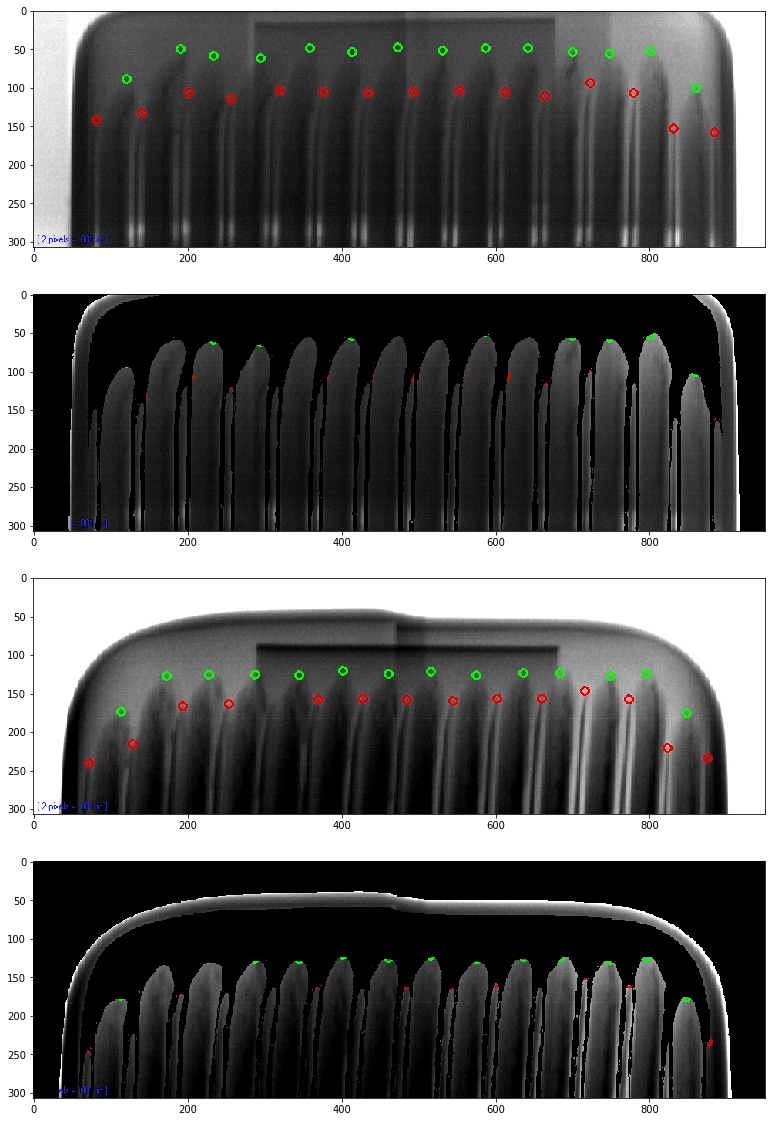

In [81]:
files = os.listdir('data/draw/')
files = np.random.choice(files, 2, replace=False)
fig, axes = plt.subplots(4, 1, figsize=(20, 20))
for i, file in enumerate(files):
    img = cv2.imread(f'data/draw/{file}')
    mask = cv2.imread(f'data/mask_all/{file}')
    
    axes[i*2].imshow(img)
    axes[i*2+1].imshow(img*(mask>0))